<a href="https://colab.research.google.com/github/17092003vamsi/HUNTER/blob/main/roc_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0083 - loss: 1.8908    
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2418 - loss: 1.8296 
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4847 - loss: 1.7024 
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4760 - loss: 1.5853 
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5690 - loss: 1.4792  
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7481 - loss: 1.3273 
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7849 - loss: 1.2242 
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8462 - loss: 1.0710  
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8622 - loss: 1.0284 
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8932 - loss: 0.8982 
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9298 - loss: 0.7384 
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9361

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
KNN Test Accuracy: 0.8128
Random Forest Test Accuracy: 0.9305
SVM Test Accuracy: 0.9626
Meta-Learner (Neural Network) Test Accuracy: 0.9626


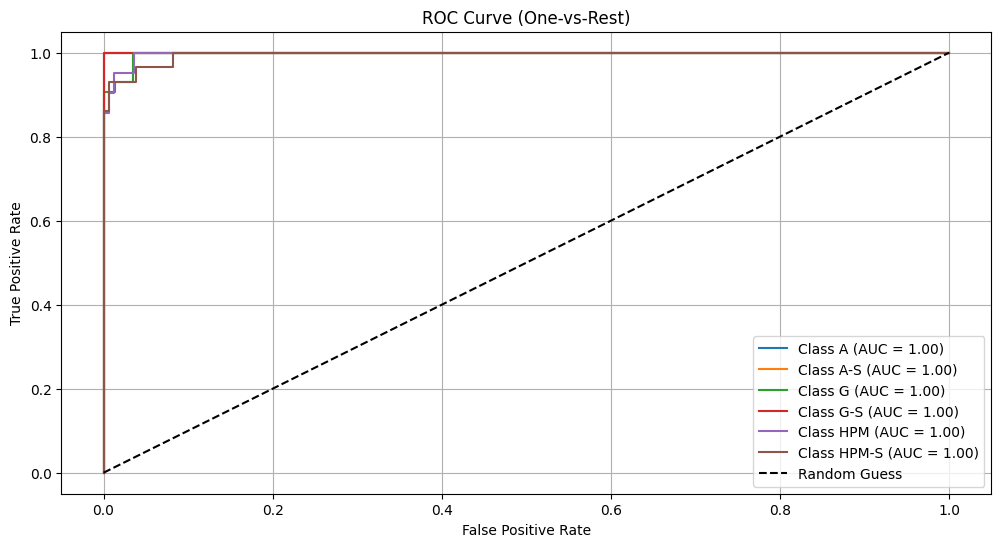

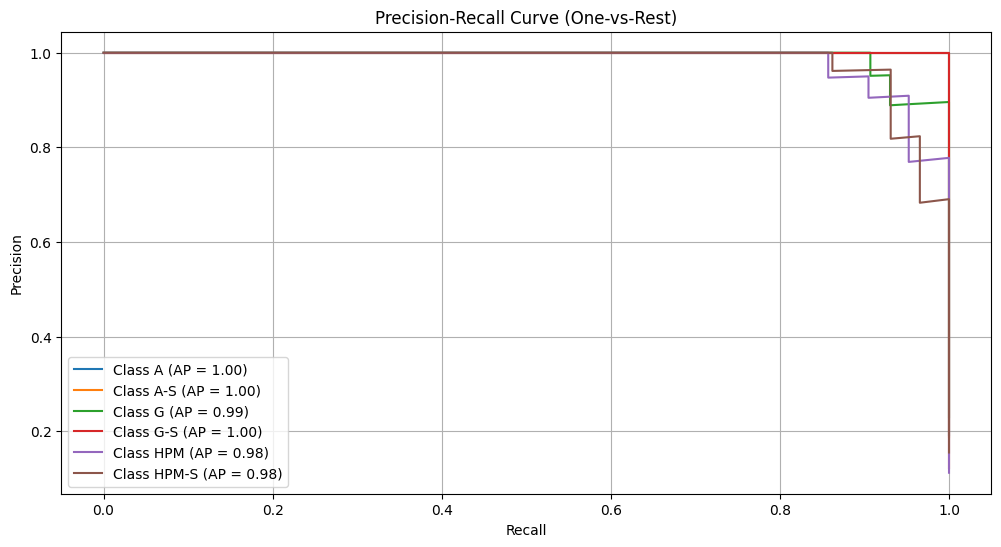

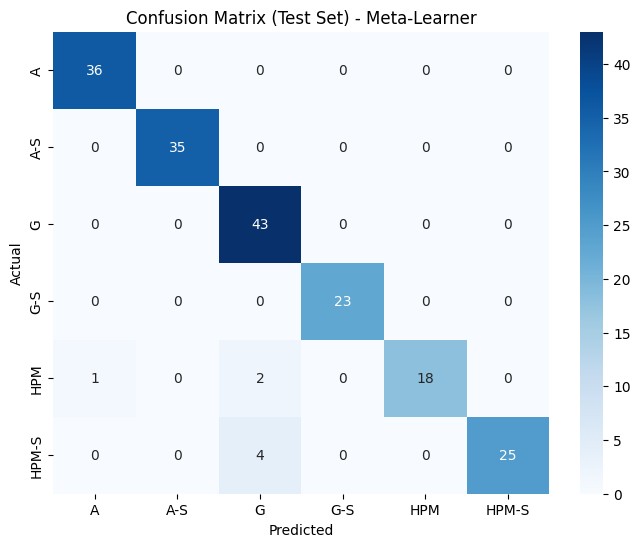

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Load the dataset
file_path = 'project 2 sap.csv'  # Update with your file path
data = pd.read_csv(file_path)

# Preprocessing
label_encoder = LabelEncoder()
data['Lable'] = label_encoder.fit_transform(data['Lable'])  # Encode target labels
y = data['Lable']
X = data.drop(columns=['Type', 'Lable'])

# Handle missing values and scale features
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# One-hot encode the labels for the neural network
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

# Base models
knn_model = KNeighborsClassifier(n_neighbors=5)
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(kernel='linear', probability=True)

# Train base models
knn_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

# Get probabilities for stacking
knn_val_proba = knn_model.predict_proba(X_val)
rf_val_proba = rf_model.predict_proba(X_val)
svm_val_proba = svm_model.predict_proba(X_val)

meta_X_val = np.hstack((knn_val_proba, rf_val_proba, svm_val_proba))

# Define and train the feedforward neural network as the meta-learner
meta_learner = Sequential([
    Dense(32, activation='relu', input_shape=(meta_X_val.shape[1],)),
    Dense(16, activation='relu'),
    Dense(y_val_onehot.shape[1], activation='softmax')
])

meta_learner.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
meta_learner.fit(meta_X_val, y_val_onehot, epochs=20, batch_size=16, verbose=1)

# Predictions on test set
knn_test_proba = knn_model.predict_proba(X_test)
rf_test_proba = rf_model.predict_proba(X_test)
svm_test_proba = svm_model.predict_proba(X_test)

meta_X_test = np.hstack((knn_test_proba, rf_test_proba, svm_test_proba))
meta_test_preds_proba = meta_learner.predict(meta_X_test)
meta_test_preds = np.argmax(meta_test_preds_proba, axis=1)

# Test accuracies for all models
knn_test_accuracy = accuracy_score(y_test, knn_model.predict(X_test))
rf_test_accuracy = accuracy_score(y_test, rf_model.predict(X_test))
svm_test_accuracy = accuracy_score(y_test, svm_model.predict(X_test))
meta_test_accuracy = accuracy_score(y_test, meta_test_preds)

print(f"KNN Test Accuracy: {knn_test_accuracy:.4f}")
print(f"Random Forest Test Accuracy: {rf_test_accuracy:.4f}")
print(f"SVM Test Accuracy: {svm_test_accuracy:.4f}")
print(f"Meta-Learner (Neural Network) Test Accuracy: {meta_test_accuracy:.4f}")

# Plot ROC Curve (OvR)
plt.figure(figsize=(12, 6))
for i, class_label in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test == i, meta_test_preds_proba[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Plot Precision-Recall Curve (OvR)
plt.figure(figsize=(12, 6))
for i, class_label in enumerate(label_encoder.classes_):
    precision, recall, _ = precision_recall_curve(y_test == i, meta_test_preds_proba[:, i])
    ap_score = average_precision_score(y_test == i, meta_test_preds_proba[:, i])
    plt.plot(recall, precision, label=f"Class {class_label} (AP = {ap_score:.2f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (One-vs-Rest)')
plt.legend(loc='lower left')
plt.grid()
plt.show()

# Confusion matrix for the meta-learner
conf_matrix = confusion_matrix(y_test, meta_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Test Set) - Meta-Learner')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
